### Nutri-score Project - Decision Modeling - Master BDMA 2025/2026

**Notebook 5: Other Group Comparison**

This notebook validates the project's models against an external dataset provided by another group.

**Objectives**

1. **External Validation**: Load and validate a secondary food database from another project group, ensuring it meets the non-overlap requirement.
2. **Comparative Analysis**: Apply our developed models (e.g., MR-Sort) to this external dataset and compare the resulting distributions and individual classifications with the other group's findings or original labels.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.isotonic import IsotonicRegression
from scipy.stats import spearmanr
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import model_utils
warnings.filterwarnings('ignore')


#### Validate the Databases

In [2]:
# Load and validate database
df = model_utils.load_food_database('data/food_database.xlsx')
model_utils.validate_database(df)

Database loaded: 353 products

=== DATABASE VALIDATION ===
Total products: 353
✓ Database size requirement met

Nutri-Score Distribution:
  ✓ Class A: 71 (20.11%)
  ✓ Class B: 70 (19.83%)
  ✓ Class C: 84 (23.8%)
  ✓ Class D: 59 (16.71%)
  ✓ Class E: 69 (19.55%)

Green-Score Distribution:
  ✓ Class A: 92 (26.06%)
  ✓ Class B: 102 (28.9%)
  ✓ Class C: 56 (15.86%)
  ✓ Class D: 49 (13.88%)
  ✓ Class E: 54 (15.3%)


In [3]:
# Load and validate other group's database
df_other_group = model_utils.load_food_database('data/food_database_other_group.xlsx')
model_utils.validate_database(df_other_group)

Database loaded: 400 products

=== DATABASE VALIDATION ===
Total products: 400
✓ Database size requirement met

Nutri-Score Distribution:
  ✓ Class A: 66 (16.5%)
  ✓ Class B: 62 (15.5%)
  ✓ Class C: 106 (26.5%)
  ✓ Class D: 71 (17.75%)
  ✓ Class E: 95 (23.75%)

Green-Score Distribution:
  ✓ Class A: 116 (29.0%)
  ✓ Class B: 99 (24.75%)
  ✓ Class C: 74 (18.5%)
  ✓ Class D: 64 (16.0%)
  ✓ Class E: 47 (11.75%)


In [4]:
model_utils.compare_databases(df, df_other_group)


=== DATABASE COMPARISON ===
Database 1: 353 products
Database 2: 388 products
Common products: 2 (0.52%)
✓ Overlap requirement met (≤30%)


#### Other Group Distribution Analysis

In [ ]:
# Nutri-Score distribution
nutri_dist = df_other_group['nutri_score_label'].value_counts().sort_index()
nutri_pct = (nutri_dist / len(df) * 100).round(1)

print("\nNutri-Score Label Distribution:")
for label in ['A', 'B', 'C', 'D', 'E']:
    if label in nutri_dist.index:
        print(f"  Grade {label}: {nutri_dist[label]} products ({nutri_pct[label]}%)")

# Green-Score distribution
green_dist = df_other_group['green_score_label'].value_counts().sort_index()
green_pct = (green_dist / len(df) * 100).round(1)

print("\nGreen-Score Label Distribution:")
for label in ['A', 'B', 'C', 'D', 'E']:
    if label in green_dist.index:
        print(f"  Grade {label}: {green_dist[label]} products ({green_pct[label]}%)")

# Visualize label distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Nutri-Score
colors_nutri = {'A': '#16a34a', 'B': '#84cc16', 'C': '#fbbf24', 'D': '#fb923c', 'E': '#ef4444'}
colors_list_nutri = [colors_nutri.get(x, 'gray') for x in nutri_dist.index]

axes[0].bar(nutri_dist.index, nutri_dist.values, color=colors_list_nutri, edgecolor='black', linewidth=1.5)
axes[0].set_title('Nutri-Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Grade', fontsize=12)
axes[0].set_ylabel('Number of Products', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (label, count) in enumerate(zip(nutri_dist.index, nutri_dist.values)):
    axes[0].text(i, count + 0.3, f'{count}\n({nutri_pct[label]}%)', 
                ha='center', va='bottom', fontweight='bold')

# Green-Score
colors_list_green = [colors_nutri.get(x, 'gray') for x in green_dist.index]

axes[1].bar(green_dist.index, green_dist.values, color=colors_list_green, edgecolor='black', linewidth=1.5)
axes[1].set_title('Green-Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Grade', fontsize=12)
axes[1].set_ylabel('Number of Products', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

for i, (label, count) in enumerate(zip(green_dist.index, green_dist.values)):
    axes[1].text(i, count + 0.3, f'{count}\n({green_pct[label]}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#### MR Sort Algorithm

In [ ]:
# Check if alternative is at least as good as profile using MR-Sort rule

def MRSort_assign(alternative, profile, weights, lambda_threshold, criteria_directions):
    weight_sum = 0
    for criterion, weight in weights.items():
        a_val = alternative[criterion]
        p_val = profile[criterion]
        if criteria_directions[criterion] == 'max':
            if a_val >= p_val:
                weight_sum += weight
        else:  # min
            if a_val <= p_val:
                weight_sum += weight
    return weight_sum >= lambda_threshold

In [ ]:
# Classify alternative into categories using MR-Sort
# This function implements both pessimistic and optimistic classification methods

def MRSort_classify_pessimistic(alternative, profiles, weights, lambda_threshold, criteria_directions):
    """Pessimistic: decrease k from r-1 until first k where a S π_k (ETRI-B-pc)"""
    for k in range(len(profiles) - 1, -1, -1):
        profile = profiles.iloc[k]
        if MRSort_assign(alternative, profile, weights, lambda_threshold, criteria_directions):
            return k + 1
    return 0  # Worst category (E)

def MRSort_classify_optimistic(alternative, profiles, weights, lambda_threshold, criteria_directions):
    """Optimistic: increase k from 1 until first k where π_k P a (ETRI-B-pd)"""
    for k in range(len(profiles)):
        profile = profiles.iloc[k]
        # π_k P a: π_k S a AND NOT a S π_k
        profile_outranks_a = MRSort_assign(profile, alternative, weights, lambda_threshold, criteria_directions)
        a_outranks_profile = MRSort_assign(alternative, profile, weights, lambda_threshold, criteria_directions)
        if profile_outranks_a and not a_outranks_profile:
            return k
    return len(profiles)  # Best category (A)

def MRSort_classify(alternative, profiles, weights, lambda_threshold, criteria_directions, method='pessimistic'):
    if method == 'pessimistic':
        return MRSort_classify_pessimistic(alternative, profiles, weights, lambda_threshold, criteria_directions)
    return MRSort_classify_optimistic(alternative, profiles, weights, lambda_threshold, criteria_directions)

In [ ]:
# Evaluate model accuracy on reference assignments

def evaluate_mrsort_model(df, profiles, weights, lambda_threshold, criteria_cols, criteria_directions, assignment_col='nutri_score_label'):
    label_to_idx = {'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}
    df = df.copy()
    df['target_category'] = df[assignment_col].map(label_to_idx)
    
    correct = 0
    criteria_directions_dict = criteria_directions
    
    for idx, row in df.iterrows():
        alternative = row[criteria_cols].to_dict()
        predicted = MRSort_classify(alternative, profiles, weights, lambda_threshold, criteria_directions_dict)
        true_category = label_to_idx.get(row[assignment_col], 0)
        if predicted == true_category:
            correct += 1
    
    return correct / len(df)

In [ ]:
def create_profiles_quantile_mrsort(df, criteria_cols, n_categories=5):
    """Create 4 limiting profiles for 5 categories using quantiles"""
    profiles = []
    quantiles = [0.20, 0.40, 0.60, 0.80]
    for q in quantiles:
        profile = {col: df[col].quantile(q) for col in criteria_cols}
        profiles.append(profile)
    profiles_df = pd.DataFrame(profiles)
    profiles_df.index = ['π2(E/D)', 'π3(D/C)', 'π4(C/B)', 'π5(B/A)']
    return profiles_df

In [ ]:
def mrsort_confusion_analysis(df, weights, profiles, lambda_threshold=0.6, method='pessimistic'):
    labels = ['E', 'D', 'C', 'B', 'A']    
    criteria_cols = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 
                    'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
    
    # Filter to available columns only
    available_cols = [col for col in criteria_cols if col in df.columns]
    print(f"✅ Using {len(available_cols)}/{len(criteria_cols)} criteria: {available_cols}")

    if weights is None:
        weights = {col: 1.0/7 for col in criteria_cols}
    if profiles is None:
        profiles = create_profiles_quantile_mrsort(df, criteria_cols)
    
    criteria_directions = {
        'energy_100g': 'min', 'saturated_fat_100g': 'min', 'sugars_100g': 'min',
        'salt_100g': 'min', 'proteins_100g': 'max', 'fiber_100g': 'max', 
        'fvl_percent': 'max', 'green_score_value': 'max' 
    }
    
    # Generate predictions
    y_true = df['nutri_score_label'].values
    y_pred = []
    
    for idx, row in df.iterrows():
        alt = row[available_cols].to_dict()
        pred_idx = MRSort_classify(alt, profiles, weights, lambda_threshold, 
                                 criteria_directions, method)
        y_pred.append(labels[pred_idx])
    
    # METRICS
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    cm = confusion_matrix(y_true, y_pred, labels=['E','D','C','B','A'])
    
    print(f"\n📊 MR-Sort {method.title()} Results")
    print(f"Overall Accuracy: {accuracy:.1%} ({accuracy*len(df):.0f}/{len(df)})")
    
    # Compute percentages (row-normalized)
    percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Dual annotation: count + %
    labels = np.asarray([[f'{c}\n({p:.0f}%)' for c, p in zip(row, perc_row)] 
                        for row, perc_row in zip(cm, percentages)])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['E','D','C','B','A'],
                yticklabels=['E','D','C','B','A'],
                cbar_kws={'label': 'Count'},
                annot_kws={"size": 14, "weight": "bold"})

    plt.title(f'MR-Sort {method.title()} Confusion Matrix\n'
              f'Accuracy: {accuracy:.1%} | λ={lambda_threshold} | {len(available_cols)} criteria')
    plt.ylabel('True Nutri-Score'); plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # PER-CATEGORY ACCURACY
    print("\nPer-category accuracy:")
    for label in ['E', 'D', 'C', 'B', 'A']:
        mask = y_true == label
        cat_acc = (np.array(y_pred)[mask] == label).mean()
        print(f"  {label}: {cat_acc:.1%} ({mask.sum()} samples)")
    
    print("\n" + classification_report(y_true, y_pred))
    
    return {'accuracy': accuracy, 'y_true': y_true, 'y_pred': y_pred, 'cm': cm}

#### Our Dataset

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 43.1% (152/353)


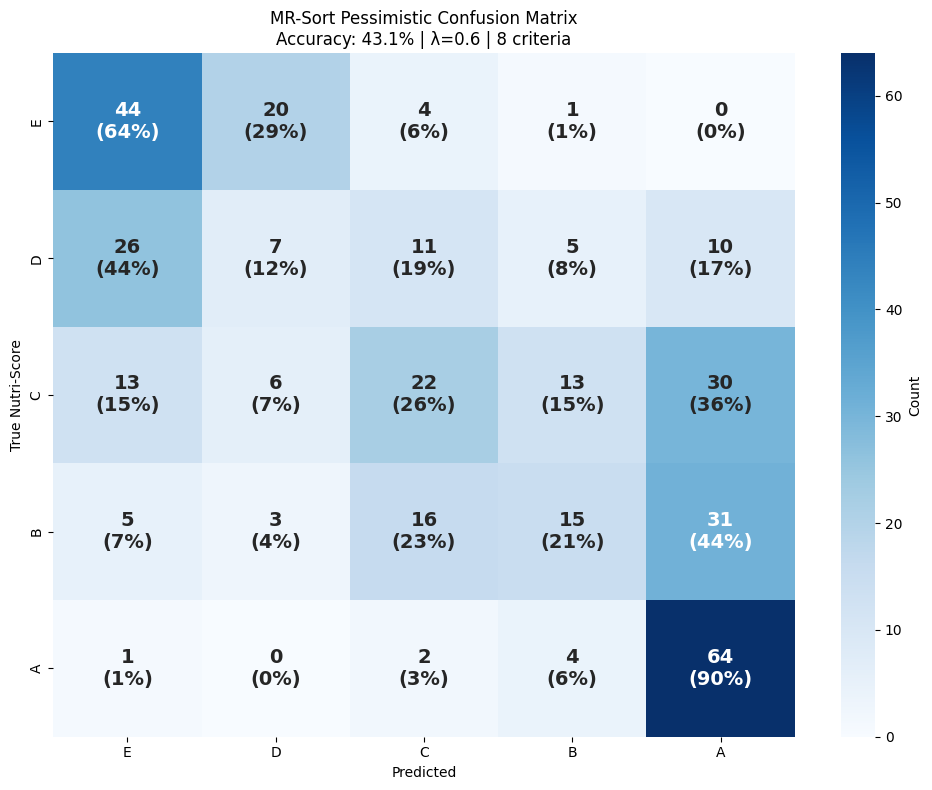


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 11.9% (59 samples)
  C: 26.2% (84 samples)
  B: 21.4% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.47      0.90      0.62        71
           B       0.39      0.21      0.28        70
           C       0.40      0.26      0.32        84
           D       0.19      0.12      0.15        59
           E       0.49      0.64      0.56        69

    accuracy                           0.43       353
   macro avg       0.39      0.43      0.38       353
weighted avg       0.40      0.43      0.39       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 43.1% (152/353)


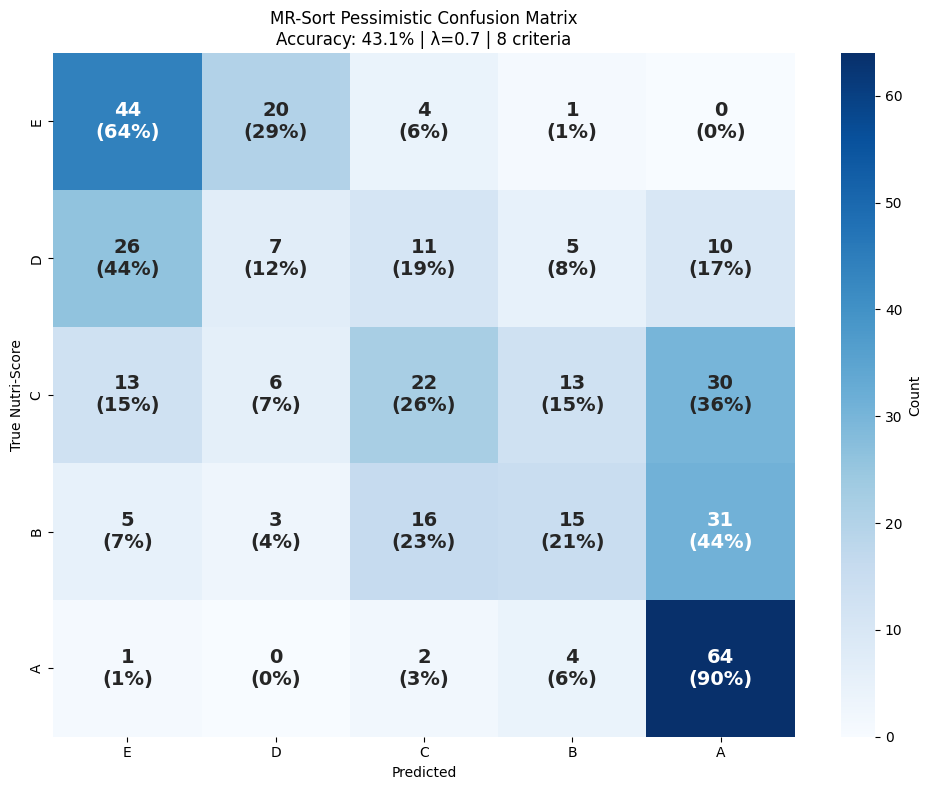


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 11.9% (59 samples)
  C: 26.2% (84 samples)
  B: 21.4% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.47      0.90      0.62        71
           B       0.39      0.21      0.28        70
           C       0.40      0.26      0.32        84
           D       0.19      0.12      0.15        59
           E       0.49      0.64      0.56        69

    accuracy                           0.43       353
   macro avg       0.39      0.43      0.38       353
weighted avg       0.40      0.43      0.39       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


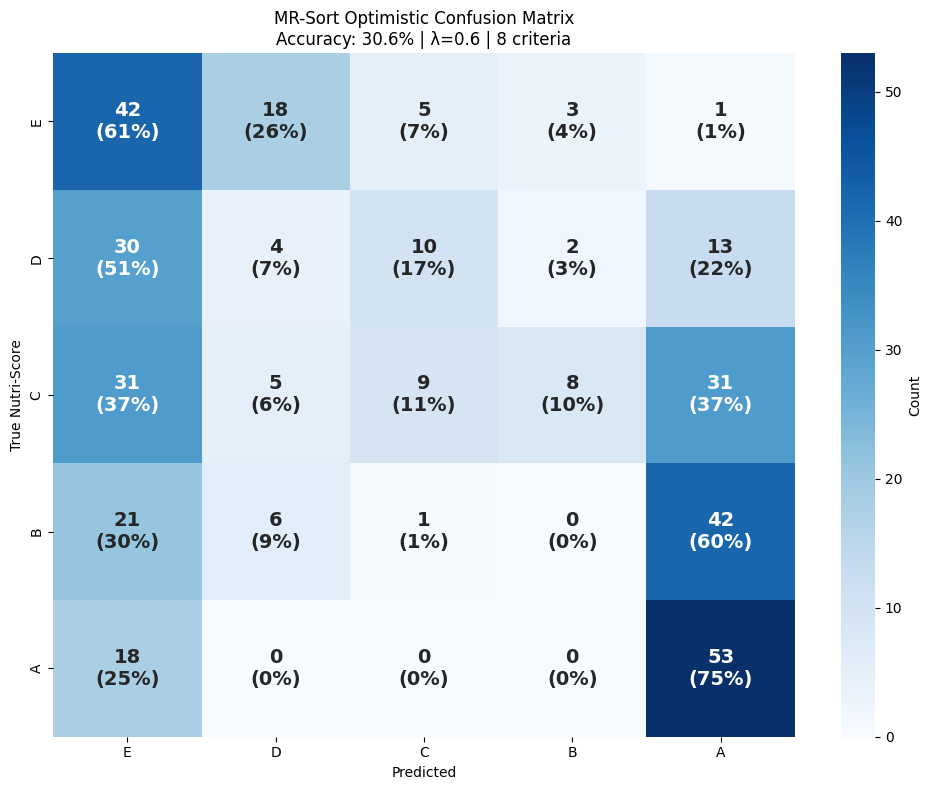


Per-category accuracy:
  E: 60.9% (69 samples)
  D: 6.8% (59 samples)
  C: 10.7% (84 samples)
  B: 0.0% (70 samples)
  A: 74.6% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.75      0.50        71
           B       0.00      0.00      0.00        70
           C       0.36      0.11      0.17        84
           D       0.12      0.07      0.09        59
           E       0.30      0.61      0.40        69

    accuracy                           0.31       353
   macro avg       0.23      0.31      0.23       353
weighted avg       0.24      0.31      0.23       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


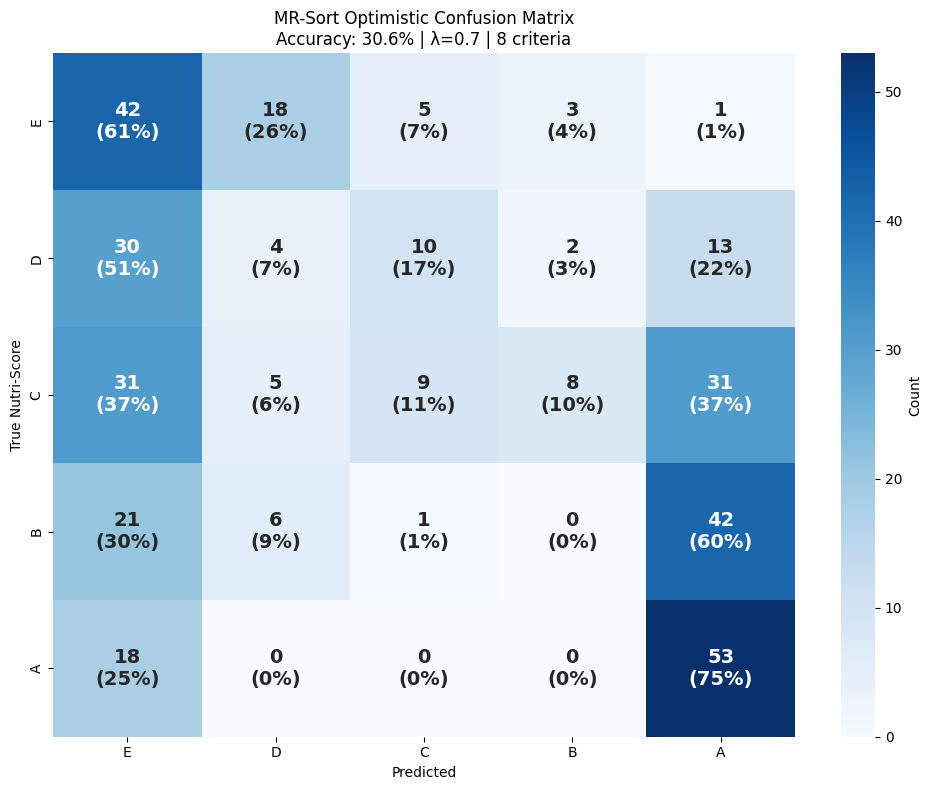


Per-category accuracy:
  E: 60.9% (69 samples)
  D: 6.8% (59 samples)
  C: 10.7% (84 samples)
  B: 0.0% (70 samples)
  A: 74.6% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.75      0.50        71
           B       0.00      0.00      0.00        70
           C       0.36      0.11      0.17        84
           D       0.12      0.07      0.09        59
           E       0.30      0.61      0.40        69

    accuracy                           0.31       353
   macro avg       0.23      0.31      0.23       353
weighted avg       0.24      0.31      0.23       353



In [ ]:
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='optimistic', lambda_threshold=0.7)

#### Other Group's Dataset

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 45.5% (182/400)


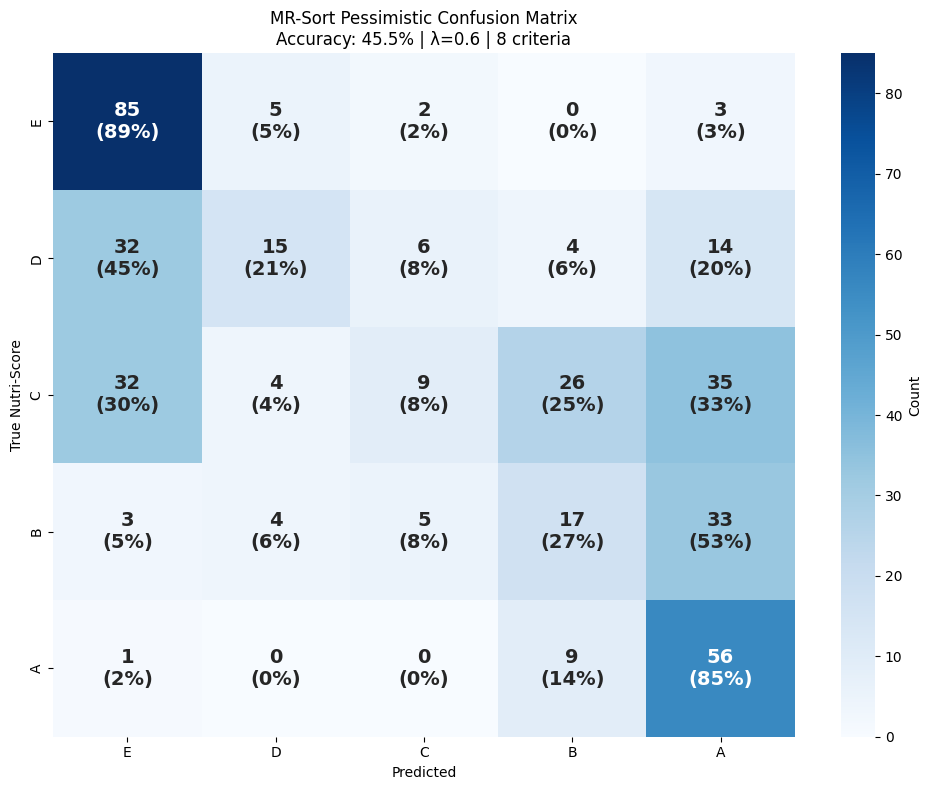


Per-category accuracy:
  E: 89.5% (95 samples)
  D: 21.1% (71 samples)
  C: 8.5% (106 samples)
  B: 27.4% (62 samples)
  A: 84.8% (66 samples)

              precision    recall  f1-score   support

           A       0.40      0.85      0.54        66
           B       0.30      0.27      0.29        62
           C       0.41      0.08      0.14       106
           D       0.54      0.21      0.30        71
           E       0.56      0.89      0.69        95

    accuracy                           0.46       400
   macro avg       0.44      0.46      0.39       400
weighted avg       0.45      0.46      0.39       400

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 45.5% (182/400)


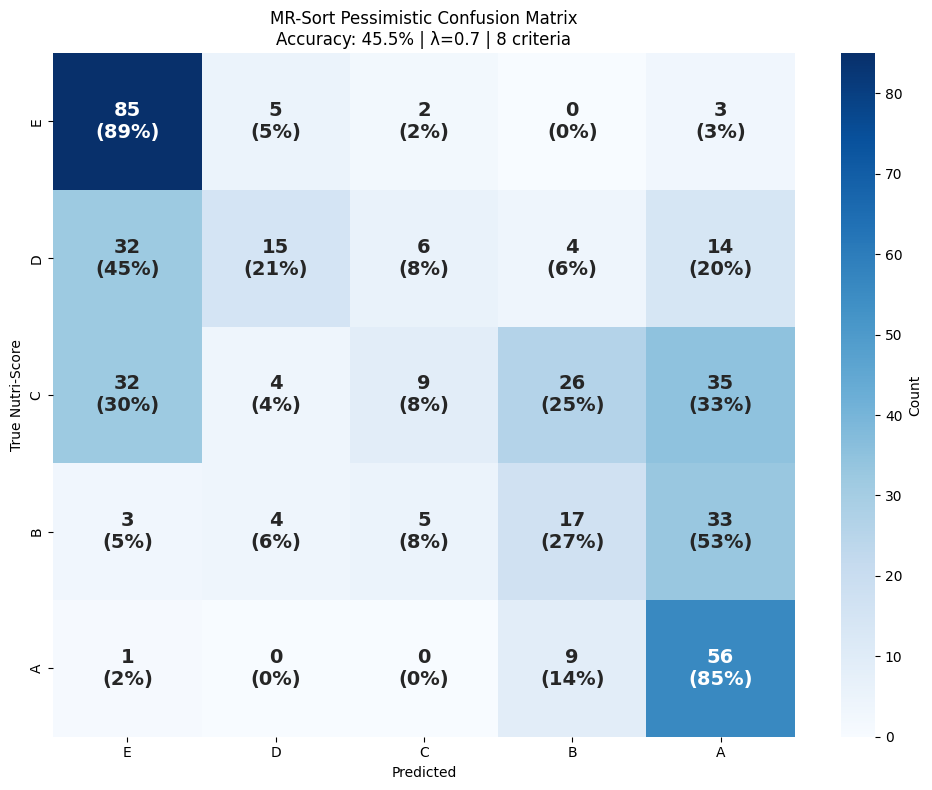


Per-category accuracy:
  E: 89.5% (95 samples)
  D: 21.1% (71 samples)
  C: 8.5% (106 samples)
  B: 27.4% (62 samples)
  A: 84.8% (66 samples)

              precision    recall  f1-score   support

           A       0.40      0.85      0.54        66
           B       0.30      0.27      0.29        62
           C       0.41      0.08      0.14       106
           D       0.54      0.21      0.30        71
           E       0.56      0.89      0.69        95

    accuracy                           0.46       400
   macro avg       0.44      0.46      0.39       400
weighted avg       0.45      0.46      0.39       400

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 36.0% (144/400)


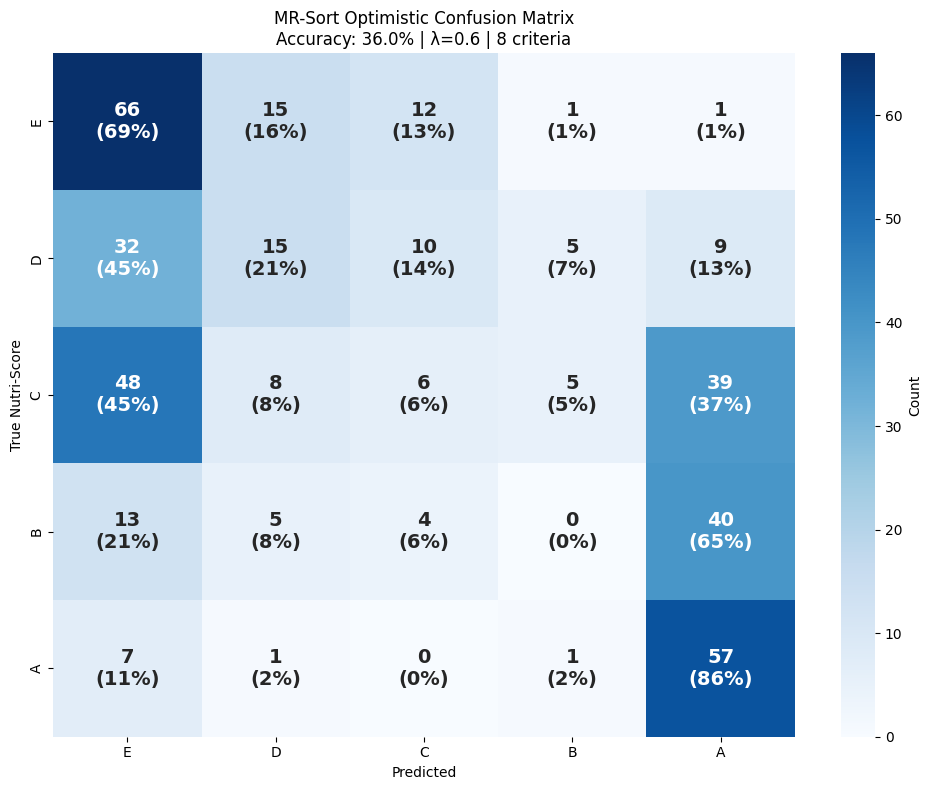


Per-category accuracy:
  E: 69.5% (95 samples)
  D: 21.1% (71 samples)
  C: 5.7% (106 samples)
  B: 0.0% (62 samples)
  A: 86.4% (66 samples)

              precision    recall  f1-score   support

           A       0.39      0.86      0.54        66
           B       0.00      0.00      0.00        62
           C       0.19      0.06      0.09       106
           D       0.34      0.21      0.26        71
           E       0.40      0.69      0.51        95

    accuracy                           0.36       400
   macro avg       0.26      0.37      0.28       400
weighted avg       0.27      0.36      0.28       400

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 36.0% (144/400)


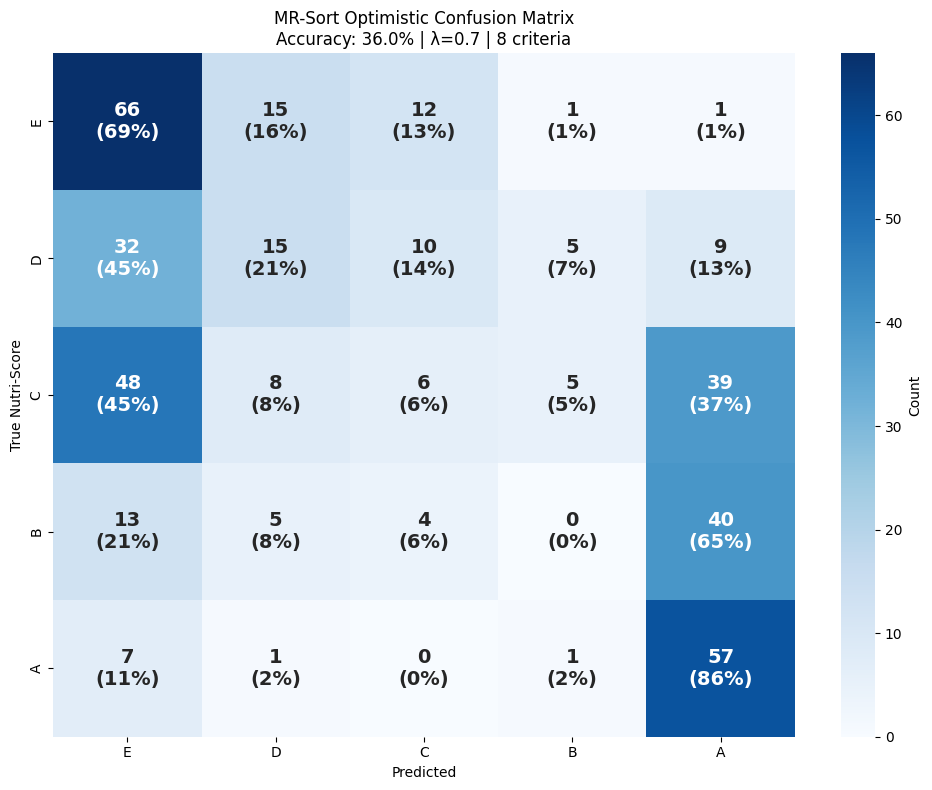


Per-category accuracy:
  E: 69.5% (95 samples)
  D: 21.1% (71 samples)
  C: 5.7% (106 samples)
  B: 0.0% (62 samples)
  A: 86.4% (66 samples)

              precision    recall  f1-score   support

           A       0.39      0.86      0.54        66
           B       0.00      0.00      0.00        62
           C       0.19      0.06      0.09       106
           D       0.34      0.21      0.26        71
           E       0.40      0.69      0.51        95

    accuracy                           0.36       400
   macro avg       0.26      0.37      0.28       400
weighted avg       0.27      0.36      0.28       400



In [ ]:
_, _, _, _ = mrsort_confusion_analysis(df_other_group, None, None, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df_other_group, None, None, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df_other_group, None, None, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df_other_group, None, None, method='optimistic', lambda_threshold=0.7)

In [ ]:
weights_optimal = {'energy_100g': np.float64(0.06848415607702134),
 'saturated_fat_100g': np.float64(0.2128588362840498),
 'sugars_100g': np.float64(0.13824387475254973),
 'salt_100g': np.float64(0.4088220911907629),
 'proteins_100g': np.float64(0.07575266482185546),
 'fiber_100g': np.float64(0.07102152798817198),
 'fvl_percent': np.float64(0.017393587050708943),
 'green_score_value': np.float64(0.007423261834879819)}

thresholds_optimal = [np.float64(0.730570602016196),
 np.float64(0.7889607899489098),
 np.float64(0.8136267461413131),
 np.float64(0.8304929697625452)]

In [ ]:
def normalize_data(df, columns, direction_mapping=None):
    """
    Normalize data for specified columns using min-max scaling with direction awareness.
    
    Args:
        df: Input DataFrame
        columns: List of column names to normalize
        direction_mapping: Dict {column: 'minimize'|'maximize'} or None for defaults
    
    Returns:
        DataFrame with normalized columns (higher values = better)
    """
    df_norm = df.copy()
    
    # Default directions: minimize bad nutrients, maximize good ones
    default_directions = {
        'energy_100g': 'minimize',
        'saturated_fat_100g': 'minimize', 
        'sugars_100g': 'minimize',
        'salt_100g': 'minimize',
        'proteins_100g': 'maximize',
        'fiber_100g': 'maximize',
        'fvl_percent': 'maximize',
        'green_score': 'maximize'
    }
    
    directions = default_directions if direction_mapping is None else direction_mapping
    
    for col in columns:
        if col in df.columns:
            series = df[col]
            min_val = series.min()
            max_val = series.max()
            
            if max_val == min_val:
                df_norm[col] = 1.0
            else:
                direction = directions.get(col, 'maximize')
                if direction == 'minimize':
                    df_norm[col] = (max_val - series) / (max_val - min_val)
                else:
                    df_norm[col] = (series - min_val) / (max_val - min_val)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame")
            df_norm[col] = 0.0
    
    return df_norm


In [ ]:
def weighted_sum_confusion_analysis(df, experiment_name, weights=None, thresholds=None):
    """
    Runs a Weighted Sum experiment using the provided weights dictionary.
    
    Args:
        df: DataFrame.
        experiment_name: Title for the output.
        weights: Dictionary {column_name: weight_value}. 
                 Must include all columns you want to score (nutrients + green score).
                 Weights should ideally sum to 1.0.
    """
    # 1. Setup Default Weights if None
    if weights is None:
        nutri_criteria = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 
                          'proteins_100g', 'fiber_100g', 'fvl_percent']
        weights = {col: 1.0/len(nutri_criteria) for col in nutri_criteria}

    # 2. Normalize Data for all columns present in 'weights'
    relevant_cols = list(weights.keys())
    df_norm = normalize_data(df, relevant_cols)
    
    # 3. Calculate Weighted Score
    scores = np.zeros(len(df))
    for col, w in weights.items():
        if col in df_norm.columns:
            scores += df_norm[col] * w
            
    # 4. Assign Labels
    if thresholds is None:
        thresholds = np.quantile(scores, [0.2, 0.4, 0.6, 0.8])
        
    def get_label(s):
        if s >= thresholds[3]: return 'A'
        elif s >= thresholds[2]: return 'B'
        elif s >= thresholds[1]: return 'C'
        elif s >= thresholds[0]: return 'D'
        else: return 'E'
        
    y_pred = [get_label(s) for s in scores]
    y_true = df['nutri_score_label'].values
    
    # 5. Metrics & Plotting
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=['E','D','C','B','A'])
    
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: {experiment_name}")
    print(f"{'='*80}")
    print(f"Weights Used: {list(weights.keys())}")
    print(f"Overall Accuracy:   {accuracy:.1%} ({int(accuracy*len(df))}/{len(df)})")
    
    # Compute percentages (row-normalized)
    percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Dual annotation: count + %
    labels = np.asarray([[f'{c}\n({p:.0f}%)' for c, p in zip(row, perc_row)] 
                        for row, perc_row in zip(cm, percentages)])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', 
                xticklabels=['E','D','C','B','A'],
                yticklabels=['E','D','C','B','A'],
                cbar_kws={'label': 'Count'},
                annot_kws={"size": 14, "weight": "bold"})

    plt.title(f'{experiment_name}\nAccuracy: {accuracy:.1%}')
    plt.xlabel('Predicted (Weighted Sum)')
    plt.ylabel('True Nutri-Score')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                               labels=['E','D','C','B','A'], zero_division=0))
    
    # return {'accuracy': accuracy, 'weights': weights}

In [ ]:
weighted_sum_confusion_analysis(
    df_other_group, 
    experiment_name="Optimal Weights, Optimal Thresholds",
    weights=weights_optimal,
    thresholds=thresholds_optimal)


EXPERIMENT: Optimal Weights, Optimal Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   51.2% (204/400)


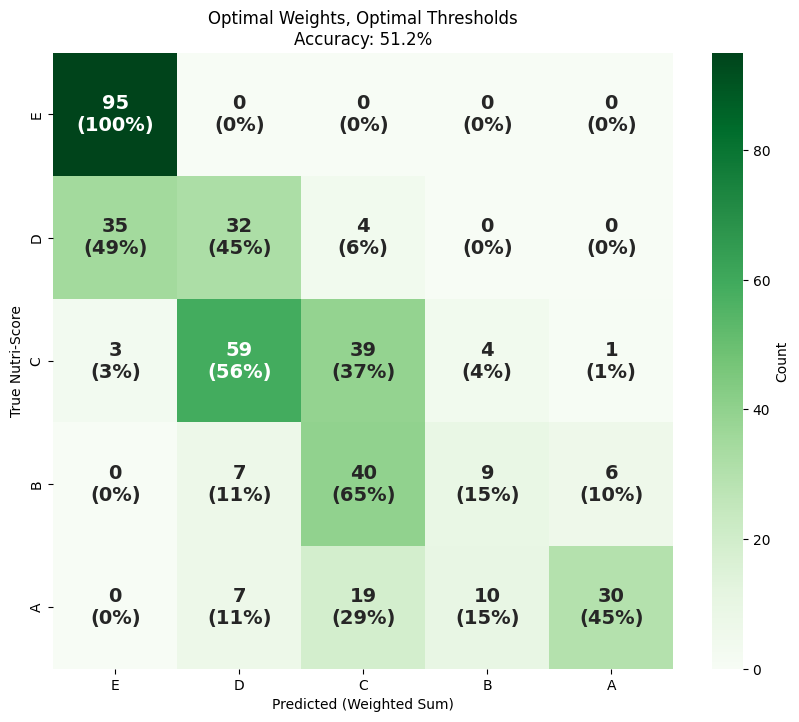


Classification Report:
              precision    recall  f1-score   support

           E       0.71      1.00      0.83        95
           D       0.30      0.45      0.36        71
           C       0.38      0.37      0.38       106
           B       0.39      0.15      0.21        62
           A       0.81      0.45      0.58        66

    accuracy                           0.51       400
   macro avg       0.52      0.48      0.47       400
weighted avg       0.52      0.51      0.49       400



In [ ]:
weighted_sum_confusion_analysis(
    df_other_group, 
    experiment_name="Optimal Weights, Optimal Thresholds",
    weights=weights_optimal,
    thresholds=thresholds_optimal)